In [1]:
import jax
import jax.numpy as jnp
import scipy.constants as const
import numpy as np
#import pandas as pd
import warnings
#import sys
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
#import tracemalloc
#import spectrum_ellipsoid_jax as sj

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import corner
import matplotlib as mpl

In [2]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : 16,#fontsize,
          "text.usetex" : True,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()],
          "text.latex.preamble" : r"\usepackage{amsmath}"}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

In [3]:
N = 1000000
initial = jnp.array([0, 0,0, 0, np.log(1.2), np.pi/4, 0, 0])
initial_spec = jnp.array([0,0, 0, np.log(1.2), np.pi/4, 0, 0, 0])

In [4]:
cov = np.genfromtxt('../data/cov_a2_t1_8p_ck.csv', delimiter = ',')

eig, ev = np.linalg.eig(np.linalg.inv(cov))
if not np.all(eig > 0):
    ind = np.where(eig < 0)[0][0]
    eig[ind] = 1e-6
    hes = ev.dot(np.diag(eig).dot(ev.T))
    cov = np.linalg.inv(hes)

In [5]:
# v, d, tau, n, eta, theta, phi, em
hes = np.linalg.inv(cov)
hes[[0,1]] = hes[[1,0]]
hes[:,[0,1]] = hes[:,[1,0]]

hes[[6,7]] = hes[[7,6]]
hes[:,[6,7]] = hes[:,[7,6]]

inv_cov_ck = np.zeros((10,10))
inv_cov_ck[:6,:6] = hes[1:7,1:7]

inv_cov_ck[6,:6] = hes[0,1:7]
inv_cov_ck[:6,6] = hes[0,1:7]

inv_cov_ck[6,7] = hes[0,7]
inv_cov_ck[7,6] = hes[7,0]

inv_cov_ck[7,:6] = hes[7, 1:7]
inv_cov_ck[:6,7] = hes[1:7, 7]

inv_cov_ck[6,6] = hes[0,0]
inv_cov_ck[7,7] = hes[7,7]

In [6]:
data = np.random.multivariate_normal(initial, cov, size = N)

In [7]:
plot_range = [(-1,1),
             (-1,1),
             (-1.2,1.2),
             (-.5,.5),
             (-1,1.4),
             (np.pi/4-2,np.pi/4+2),
             (-1,1),
             (-1,1)]

corner_args = {'plot_datapoints' : False, 'quiet' : True,
             'plot_density' : False, 'fill_contours' : True, 
              'smooth' :1, 'levels': (1 - np.exp(-0.5),1 - np.exp(-1)),
              'hist_kwargs' : {'density':True, 'lw':2},
              'contourf_kwargs' : {'alpha':[0.0, 0.1, 0.2]},
              'labels': [r"$\log \tilde{v}_\text{ph}$",
                        r"$\log \tilde{D}_A$",
                        r"$\log \tilde{\tau}_\text{ph}$",
                        r"$\log \tilde{n}$",
                        r"$\log \eta$",
                        r"$\theta$",
                        r"$\phi$",
                        r"$\log \alpha_{em}$"],
              'max_n_ticks': 3, 'range': plot_range }

corner_args_spec = {'plot_datapoints' : False, 'quiet' : True,
             'plot_density' : False, 'fill_contours' : True, 
              'smooth' :1, 'levels': (1 - np.exp(-0.5),1 - np.exp(-1)),
              'hist_kwargs' : {'density':True, 'lw':2},
              'contourf_kwargs' : {'alpha':[0.0, 0.1, 0.2]},
              'labels': [r"$\log \tilde{v}_\text{ph}$",
                        r"$\log \tilde{D}_A$",
                        r"$\log \tilde{\tau}_\text{ph}$",
                        r"$\log \tilde{n}$",
                        r"$\log \eta$",
                        r"$\theta$",
                        r"$\phi$",
                        r"$\log \alpha_{em}$"],
              'max_n_ticks': 3,
                   'range': plot_range}

corner_args_combine = {'plot_datapoints' : False, 'quiet' : True,
             'plot_density' : False, 'fill_contours' : True, 
              'smooth' :1, 'levels': (1 - np.exp(-0.5),1 - np.exp(-1)),
              'hist_kwargs' : {'density':True, 'lw':2},
              'contourf_kwargs' : {'alpha':[0.0, 0.2, 0.5]},
              'labels': [r"$\log \tilde{v}_\text{ph}$",
                        r"$\log \tilde{D}_A$",
                        r"$\log \tilde{\tau}_\text{ph}$",
                        r"$\log \tilde{n}$",
                        r"$\log \eta$",
                        r"$\theta$",
                        r"$\phi$",
                        r"$\log \alpha_{em}$"],
              'max_n_ticks': 3,
                   'range': plot_range}

In [8]:
cov_spec = np.genfromtxt('../data/cov_a2_t1_8p_spec.csv', delimiter = ',')

tmp = np.random.multivariate_normal(initial_spec ,cov_spec, N)
data_spec = np.zeros((N,10))

data_spec[:,0] = tmp[:,0]
data_spec[:,2:6] = tmp[:,1:5]
data_spec[:,7:] = tmp[:,5:]

In [9]:
# v, tau, n, eta, theta, em, temp, norm
hes_spec = np.linalg.inv(cov_spec)

inv_cov_sp = np.zeros((10,10))
inv_cov_sp[:6,:6] = hes_spec[:6,:6]

inv_cov_sp[8, :6] = hes_spec[6, :6]
inv_cov_sp[:6, 8] = hes_spec[:6, 6]

inv_cov_sp[9, :6] = hes_spec[7, :6]
inv_cov_sp[:6, 9] = hes_spec[:6, 7]

inv_cov_sp[8, 9] = hes_spec[6, 7]
inv_cov_sp[9, 8] = hes_spec[7, 6]

inv_cov_sp[8, 8] = hes_spec[6, 6]
inv_cov_sp[9, 9] = hes_spec[7, 7]

# v, tau, n, eta, theta, em, d, phi, t, norm

In [10]:
cov_3 = np.linalg.inv(inv_cov_ck + inv_cov_sp)# - np.eye(9)*1e-1)
mu_3  = jnp.array([0, 0, 0, np.log(1.2), np.pi/4, 0,0, 0, 0, 0])
# v, tau, n, eta, theta, em, d, phi, t, norm
data_3 = np.random.multivariate_normal(mu_3, cov_3, size = N)

data_9 = np.zeros(data_3.shape)
data_9[:,0] = data_3[:,0]
data_9[:,1] = data_3[:,6]
data_9[:,2:6] = data_3[:,1:5]
data_9[:,6] = data_3[:,7]
data_9[:,7] = data_3[:,5]
data_9 = data_9[:,:8]
# v, d, tau, n, eta, theta, phi, em, t, norm

In [12]:
import matplotlib.lines as mlines

<Figure size 1400x1400 with 0 Axes>

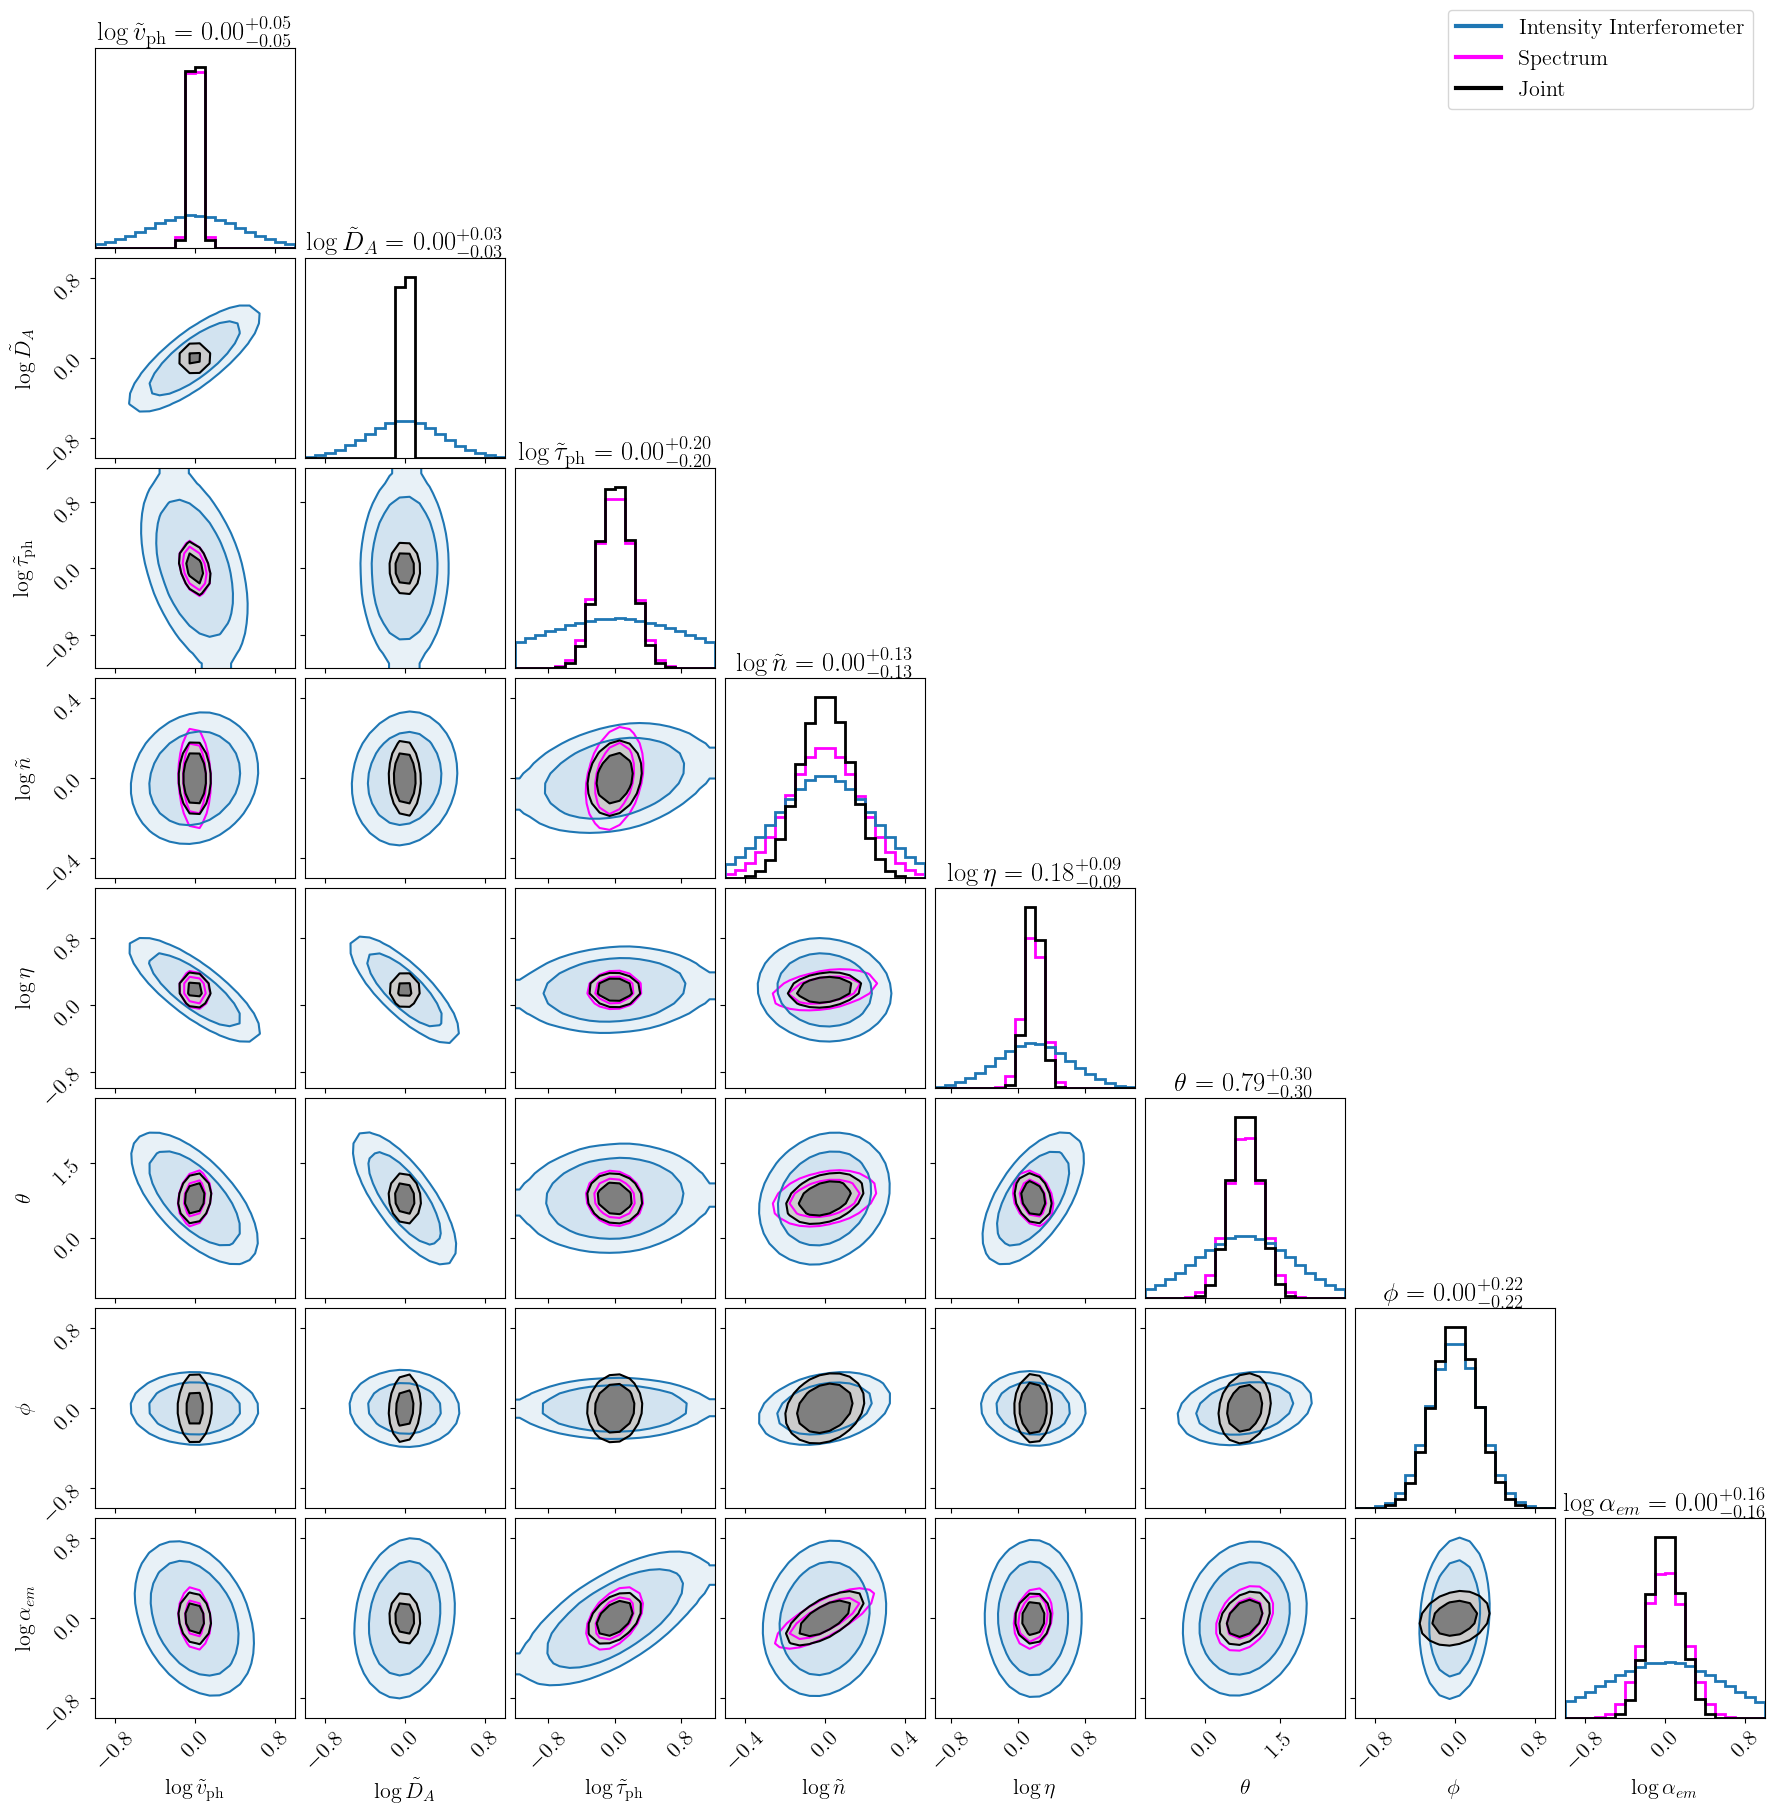

In [17]:
blue_line = mlines.Line2D([], [], color='tab:blue', label='Intensity Interferometer', lw = 3)
red_line = mlines.Line2D([], [], color='magenta', label='Spectrum', lw = 3)
black_line = mlines.Line2D([], [], color='black', label='Joint', lw = 3)

fig = plt.figure(figsize=(14, 14))

# Add a column of NaN as the first "variable" to create empty panels

# Create the corner plot
corner_plot = corner.corner(
    data_spec[:,:8], color = 'magenta',
    **corner_args_spec
)



# Get the axes array
axes = np.array(corner_plot.axes).reshape((8, 8))

# Clear the content of the first row and column panels but keep them visible
for i in range(8):
    if i >= 0:  # Skip the diagonal element
        # Clear first column
        axes[i, 1].clear()
        axes[i, 6].clear()
        
        # Clear first row (if it exists)
        if i < 6:  # Corner plot only shows lower triangle
            axes[1, i].clear()
            axes[6, i].clear()

# Clear the first diagonal element (top-left panel)
axes[1, 1].clear()
axes[6, 6].clear()

# Adjust the spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)

corner.corner(data, color = 'tab:blue',**corner_args, show_titles = False, fig = corner_plot);

corner.corner(data_9+1e-3, color = 'k',**corner_args_combine, show_titles = True, fig = corner_plot,
              );
plt.legend(handles=[blue_line,red_line, black_line], loc='upper right',bbox_to_anchor=(1, 8.6))
plt.savefig('corner_emission.pdf', bbox_inches = 'tight')